# What is ROSE and why?

**ROSE**: RADICAL Orchestrator for Surrogate Exploration (ROSE) toolkit is a framework designed to enable the concurrent and adaptive execution of simulation, surrogate training, and selection tasks on High-Performance Computing (HPC) resources. ROSE allows you to enable, scale, and accelerate your learning workflows across thousands of CPU cores and GPUs effectively and efficiently with just a few lines of code 

<div style="text-align: center;">
  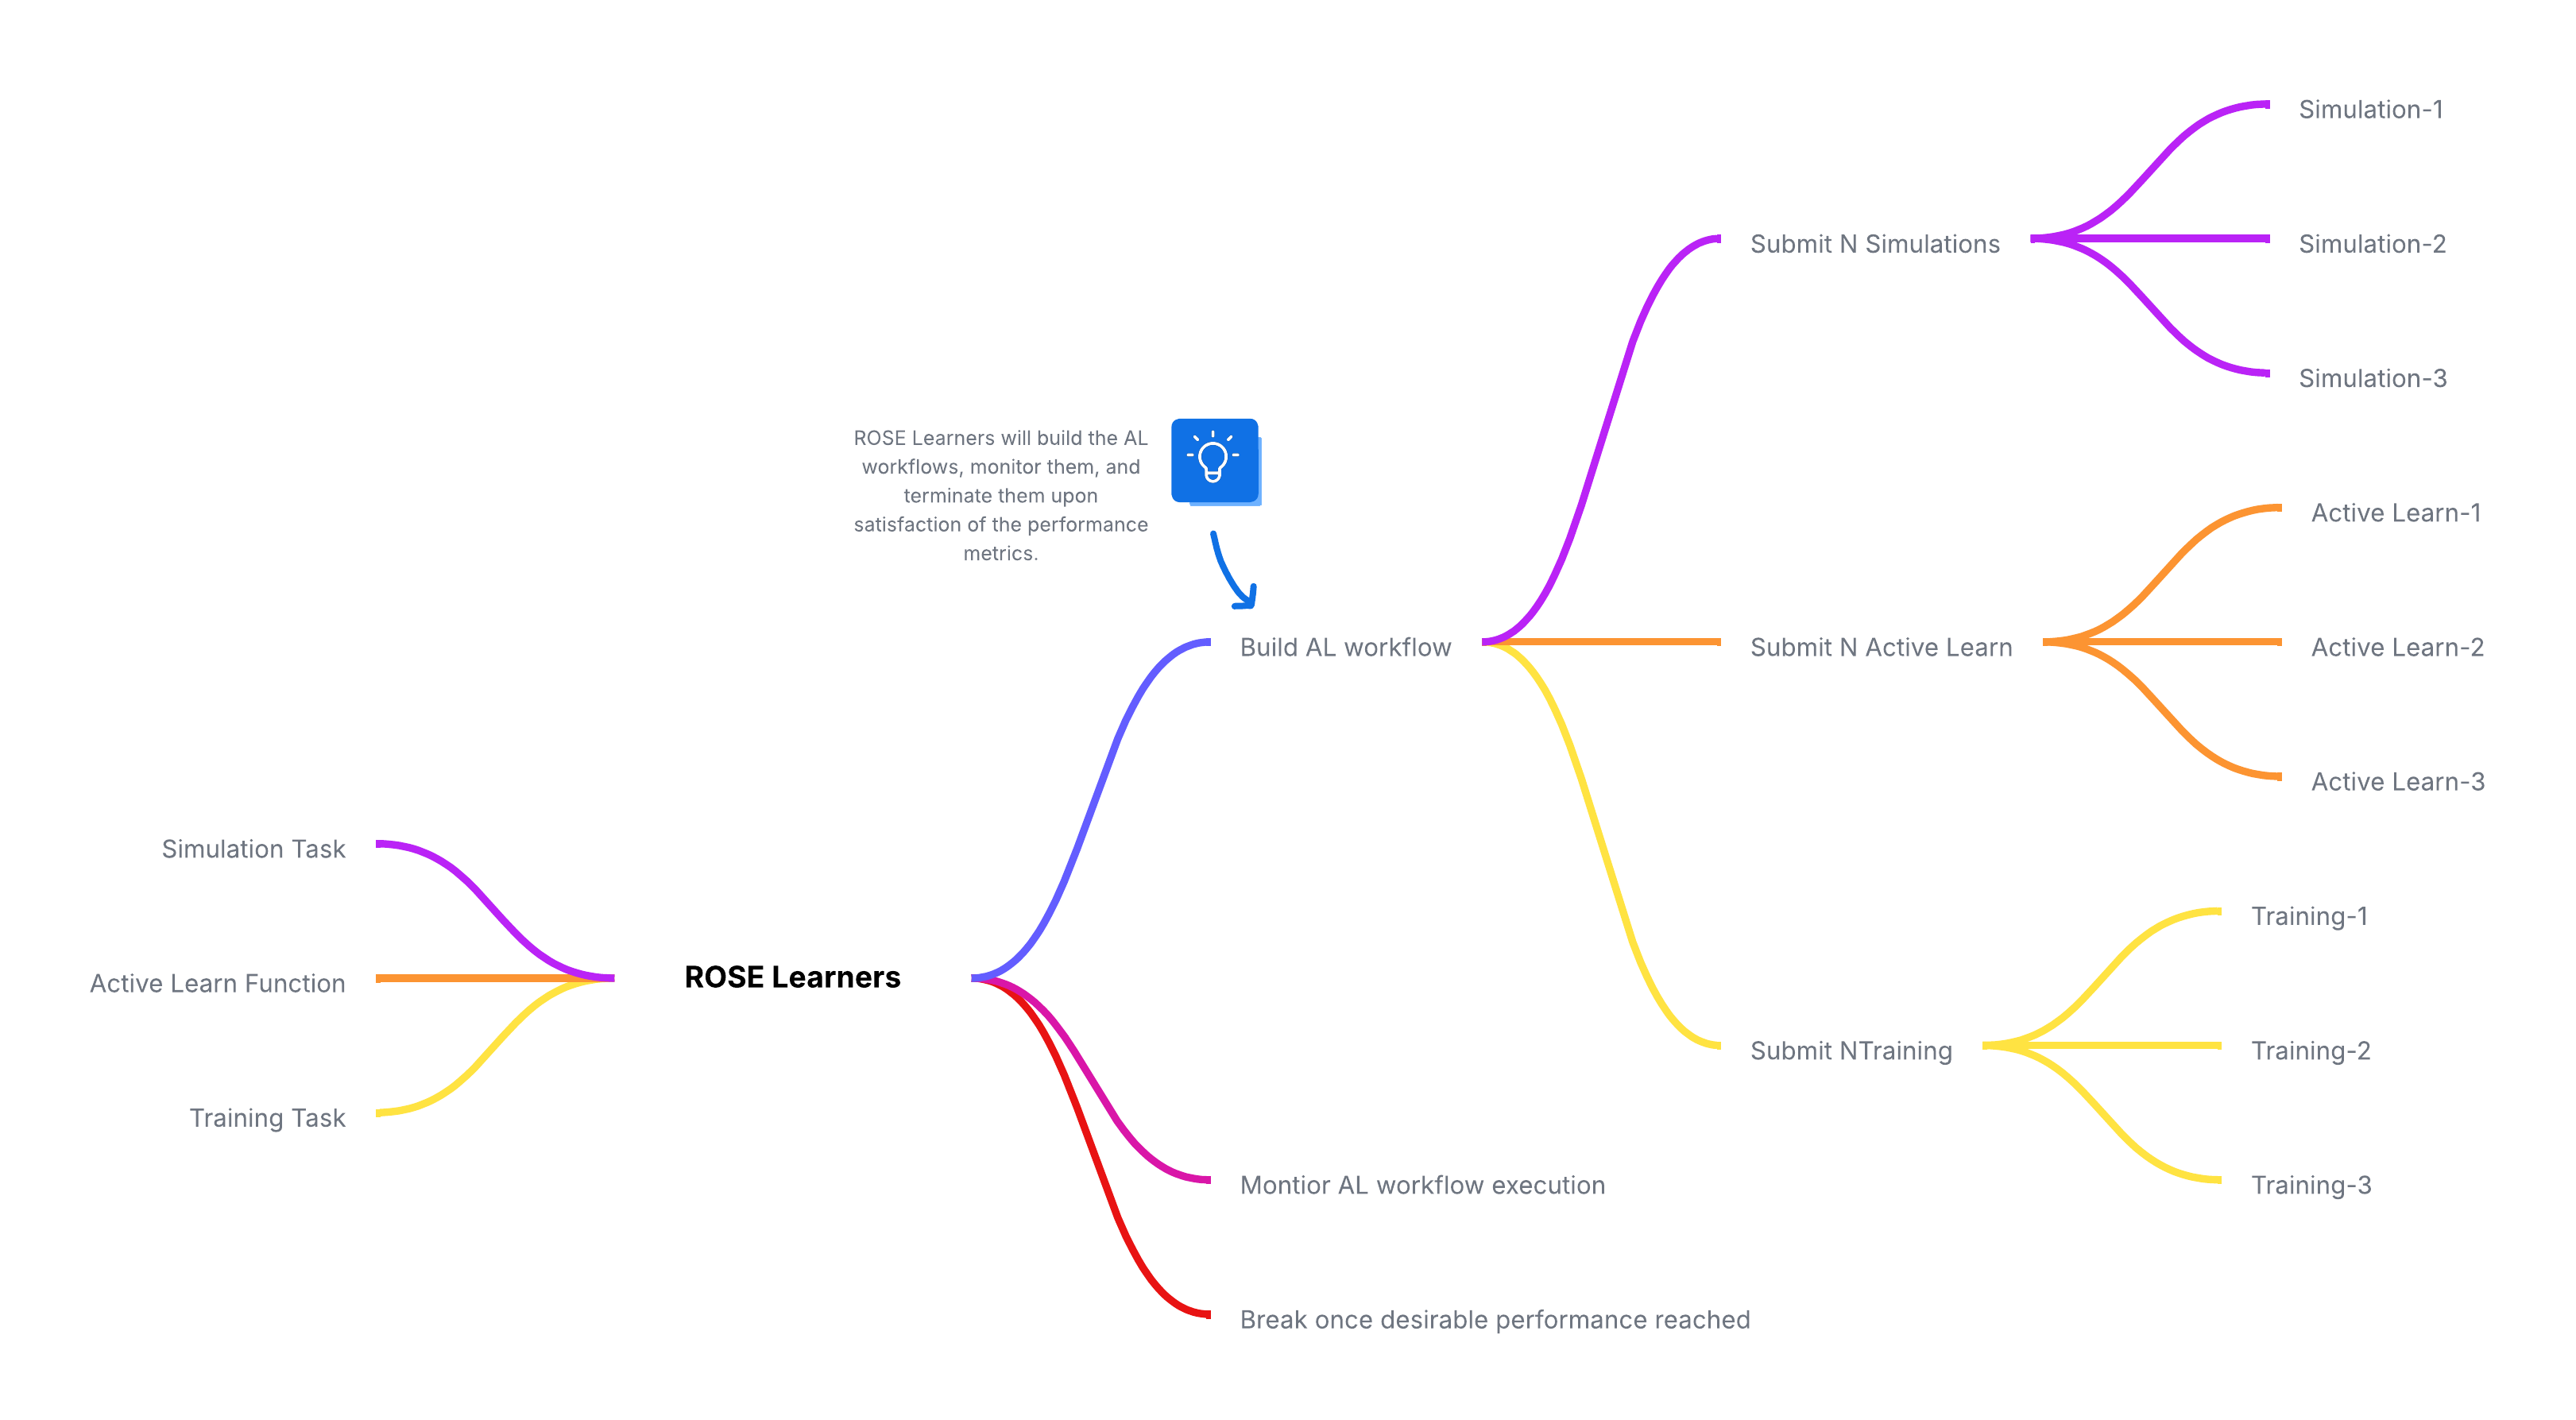
</div>



* A framework that facilitates building and executing ML learning workflows on different HPC clusters seamlessly.
* Offers multiple standardized AL, RL, UQ, and HPO (upcoming) approaches, while also allowing the flexibility to create custom ML workflows.
* Built on RCT, leveraging its runtime capabilities to execute heterogeneous tasks on heterogeneous resources.
* Open-source and Python-native.


### Why ROSE

Today’s challenge: Scientists must wire together training, simulation, and learning tasks — this is manual, fragile, not scalable, or performance efficient.

ROSE advantage:
* Automates, scales, portabilizes, and asynchronously executes workflow learners (training, active learning, UQ, RL) on a large scale on HPC efficently.

# Standardized Approach for building Learners

* Learner is a `unified` workflow that can contain `simulation` --> `training` --> `active learn` steps (tasks) and can be automated.
* Learners are often isolated and run asynchronously. ROSE also extends this notion to support learners who can communicate and depend on others accordingly.
* Within each learner user can parallelize their `simulation` --> `training` --> `active learn` steps in the best way that fits their resources and needs.
* Additionally, users can benefit from ROSE by leveraging learner-level parallelization, allowing them to submit N parallel learners and letting ROSE manage that for them on HPC.

## Outlines:
This tutorial will teach the user into how to use ROSE to build:
* Basic Surrogate Learner.
* Parallel Surrogate Learners.
* Ensemble Surrogate Learners.

## Sequential Learner

In this example, we will learn how to use ROSE API to build and submit a `single` Active Learn Learner that either stops when the performance metric threshold is `met` or the number of iterations the user specified is reached (in this case, 5 iterations).

```
                                                  ┌────────────────────────┐
                                                  │      SIMULATION        │
                                                  │ (Generate synthetic    │
                                                  │  or real-world data)   │
                                                  └────────────┬───────────┘
                                                               │
                                                               ▼
                                                  ┌────────────────────────┐
                                                  │        TRAINING        │
                                                  │ (Train model on        │
                                                  │  initial dataset)      │
                                                  └────────────┬───────────┘
                                                               │
                                                               ▼
                                                  ┌────────────────────────┐
                                                  │     ACTIVE LEARNING    │
                                                  │ (Use model to query or │
                                                  │  label uncertain data) │
                                                  └────────────┬───────────┘
                                                               │
                                                               ▼
                                                  ┌────────────────────────┐
                                                  │   IMPROVED MODEL LOOP  │
                                                  │(Repeat for N iters     │
                                                  │   or performance goal) │
                                                  └────────────────────────┘

```

In [1]:
import os
import sys
import time
import asyncio
import logging

from typing import Dict, List, Any
from dataclasses import dataclass

# learner and task level imports
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error

# ROSE top layer imports
from rose.metrics import MEAN_SQUARED_ERROR_MSE
from rose.al.active_learner import Learner, SequentialActiveLearner, ParallelActiveLearner

# ROSE Bottom layers imports
from radical.asyncflow import WorkflowEngine
from radical.asyncflow import ConcurrentExecutionBackend
from concurrent.futures import ProcessPoolExecutor
from radical.asyncflow.logging import init_default_logger

logger = logging.getLogger(__name__)

In [2]:
async def run(acl, **kwargs):
    INITIAL_SAMPLES = 10
    SAMPLES_PER_ITER = 5
    POOL_SIZE = 50
    
    # ========================================================================
    # 1. SIMULATION TASK
    # ========================================================================
    @acl.simulation_task(as_executable=False)
    async def simulation(*args, **kwargs) -> dict:
        logger.info("=== SIMULATION: Generating data ===")
        
        np.random.seed(42)
        X_all = np.linspace(0, 4 * np.pi, INITIAL_SAMPLES + POOL_SIZE).reshape(-1, 1)
        y_all = np.sin(X_all).ravel() + np.random.normal(0, 0.1, X_all.shape[0])
        
        indices = np.random.permutation(len(X_all))
        labeled_idx = indices[:INITIAL_SAMPLES]
        pool_idx = indices[INITIAL_SAMPLES:]
        
        X_test = np.linspace(0, 4 * np.pi, 100).reshape(-1, 1)
        y_test = np.sin(X_test).ravel()
        
        logger.info(f"Initial labeled: {len(labeled_idx)}, Pool: {len(pool_idx)}")
        
        return {
            "X_all": X_all,
            "y_all": y_all,
            "labeled_indices": labeled_idx.tolist(),
            "pool_indices": pool_idx.tolist(),
            "X_test": X_test,
            "y_test": y_test
        }
    
    # ========================================================================
    # 2. TRAINING TASK
    # ========================================================================
    @acl.training_task(as_executable=False)
    async def training(*args, **kwargs) -> dict:
        """
        Training depends on: simulation_task
        Args:
            args[0]: simulation result (data dict)
        """
        # Get data from args[0] (simulation result)
        data = args[0] if args else kwargs.get("data", {})
        iteration = kwargs.get("iteration", 0)
        
        logger.info(f"=== TRAINING: Iteration {iteration} ===")
        
        X_all = data["X_all"]
        y_all = data["y_all"]
        labeled_idx = np.array(data["labeled_indices"])
        X_test = data["X_test"]
        y_test = data["y_test"]
        
        X_train = X_all[labeled_idx]
        y_train = y_all[labeled_idx]
        
        kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
        model = GaussianProcessRegressor(kernel=kernel, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred, y_std = model.predict(X_test, return_std=True)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        logger.info(f"Training samples: {len(X_train)}, Test RMSE: {rmse:.4f}")
        
        return {
            "model": model,
            "rmse": rmse,
            "mean_uncertainty": np.mean(y_std),
            "labeled_indices": labeled_idx.tolist(),
            "iteration": iteration
        }
    
    # ========================================================================
    # 3. ACTIVE LEARNING TASK
    # ========================================================================
    @acl.active_learn_task(as_executable=False)
    async def active_learn(*args, **kwargs) -> dict:
        """
        Active learning depends on: (simulation_task, training_task)
        Args:
            args[0]: simulation result (data dict)
            args[1]: training result (model + metrics dict)
        """
        simulation_result = args[0]  # From sim_task
        training_result = args[1]    # From train_task

        iteration = training_result.get("iteration", 0)
        
        logger.info(f"=== ACTIVE LEARNING: Selecting samples (Iteration {iteration}) ===")
        
        # Now extract data
        model = training_result["model"]
        X_all = simulation_result["X_all"]
        labeled_idx = np.array(training_result["labeled_indices"])
        pool_idx = np.array(simulation_result["pool_indices"])
        
        # Predict uncertainty on pool
        X_pool = X_all[pool_idx]
        _, y_std = model.predict(X_pool, return_std=True)
        
        # Select top-k most uncertain
        uncertain_indices = np.argsort(y_std)[-SAMPLES_PER_ITER:]
        selected_pool_idx = pool_idx[uncertain_indices]
        
        # Update indices
        new_labeled = np.concatenate([labeled_idx, selected_pool_idx])
        new_pool = np.setdiff1d(pool_idx, selected_pool_idx)
        
        logger.info(f"Selected {len(selected_pool_idx)} uncertain samples")
        logger.info(f"Labeled: {len(labeled_idx)} -> {len(new_labeled)}")
        
        # Return updated data for next iteration
        return {
            "X_all": simulation_result["X_all"],
            "y_all": simulation_result["y_all"],
            "labeled_indices": new_labeled.tolist(),
            "pool_indices": new_pool.tolist(),
            "X_test": simulation_result["X_test"],
            "y_test": simulation_result["y_test"],
            "iteration": iteration + 1
        }

    # Run
    logger.info("Starting Active Learning with ROSE...")
    await acl.teach(**kwargs)
    logger.info("Active Learning completed!")

try:
    engine = await ConcurrentExecutionBackend(ProcessPoolExecutor())
    asyncflow = await WorkflowEngine.create(engine)
    acl = SequentialActiveLearner(asyncflow)

    init_default_logger(logging.INFO)
    await run(acl, max_iter=5)
except Exception as e:
    print(f'Learner Failed with: {e}')
finally:
    await acl.shutdown()
    logging.getLogger().handlers.clear()

2025-10-26 19:42:34.222 │ INFO │ [root] │ Logger configured successfully - Console: INFO, File: disabled (N/A), Structured: disabled, Style: modern
2025-10-26 19:42:34.223 │ INFO │ [main] │ Starting Active Learning with ROSE...
Starting Active Learner
Starting Iteration-0
2025-10-26 19:42:34.224 │ INFO │ [workflow_manager] │ Submitting ['simulation'] for execution
2025-10-26 19:42:34.299 │ INFO │ [main] │ === SIMULATION: Generating data ===
2025-10-26 19:42:34.302 │ INFO │ [main] │ Initial labeled: 10, Pool: 50
2025-10-26 19:42:34.312 │ INFO │ [workflow_manager] │ task.000001 is in DONE state
2025-10-26 19:42:35.308 │ INFO │ [workflow_manager] │ Submitting ['training'] for execution
2025-10-26 19:42:35.321 │ INFO │ [main] │ === TRAINING: Iteration 0 ===
2025-10-26 19:42:35.350 │ INFO │ [main] │ Training samples: 10, Test RMSE: 0.2109
2025-10-26 19:42:35.363 │ INFO │ [workflow_manager] │ task.000002 is in DONE state
2025-10-26 19:42:36.335 │ INFO │ [workflow_manager] │ Submitting ['acti

#### But what if I want to stop the execution earlier if my performance metric is reached?

In [3]:
@acl.as_stop_criterion(metric_name=MEAN_SQUARED_ERROR_MSE, threshold=0.1, as_executable=False)
async def check_mse():
    """
    Your stop condition
    1-For each AL iteration, check if MSE <= 0.1
    2-Terminate early if reached
    """

## Parallel Learners

When we talk about parallel learners, we mean running multiple surrogates at the same time, instead of just one. Different learners can explore different parts of the data space. Running in parallel takes advantage of modern multi-core CPUs or GPUs.

```
                   SHARED SIMULATION                  |    OWN SIMULATION PER LEARNER
                   ───────────────────────────────────|────────────────────────────────────────
                           ┌───────────────┐          |        ┌───────────────┐
                           │ SIMULATION    │          |        │ SIMULATION 1  │
                           │ (Shared)      │          |        │ (Learner 1)   │
                           └──────┬────────┘          |        └──────┬────────┘
                                  │                   |               │
                    ┌─────────────┴─────────────┐     | ┌─────────────┴─────────────┐
                    │       TRAINING 1          │     | │          TRAINING 1       │
                    │       TRAINING 2          │     | │          TRAINING 2       │
                    │       TRAINING N          │     | │          TRAINING N       │
                    └─────────────┬─────────────┘     | └─────────────┬─────────────┘
                                  │                   |               │
                    ┌─────────────┴─────────────┐     | ┌─────────────┴─────────────┐
                    │   ACTIVE LEARNING 1..N    │     | │     ACTIVE LEARNING 1     │
                    └─────────────┬─────────────┘     | │     ACTIVE LEARNING 2     │
                                  │                   | │     ACTIVE LEARNING N     │
                    ┌─────────────┴─────────────┐     | └─────────────┬─────────────┘
                    │   IMPROVED LOOP 1..N      │     | ┌─────────────┴─────────────┐
                    └───────────────────────────┘     | │     IMPROVED LOOP 1       │
                                                      | │     IMPROVED LOOP 2       │
                                                      | │     IMPROVED LOOP N       │
                                                      | └───────────────────────────┘
                               

```

In ROSE, scaling your Learners on HPC is done by using the `Parallel Learners` instead of the `Sequential Learners`. 

The example below will show how to build and launch 5 truly asynchronous and parallel learners on your compute resources in a few lines of code.

In [4]:
try:
    engine = await ConcurrentExecutionBackend(ProcessPoolExecutor())
    asyncflow = await WorkflowEngine.create(engine)
    acl = ParallelActiveLearner(asyncflow)

    init_default_logger(logging.INFO)
    await run(acl, max_iter=3, parallel_learners=2)
except Exception as e:
    print(f'Learner Failed with: {e}')
finally:
    await acl.shutdown()
    logging.getLogger().handlers.clear()

2025-10-26 19:43:06.040 │ INFO │ [root] │ Logger configured successfully - Console: INFO, File: disabled (N/A), Structured: disabled, Style: modern
2025-10-26 19:43:06.041 │ INFO │ [main] │ Starting Active Learning with ROSE...
Starting Parallel Active Learning with 2 learners
Starting Active Learner (Learner-0)
[Learner-0] Starting Iteration-0
Starting Active Learner (Learner-1)
[Learner-1] Starting Iteration-0
2025-10-26 19:43:06.043 │ INFO │ [workflow_manager] │ Submitting ['simulation', 'simulation'] for execution
2025-10-26 19:43:06.114 │ INFO │ [main] │ === SIMULATION: Generating data ===
2025-10-26 19:43:06.114 │ INFO │ [main] │ === SIMULATION: Generating data ===
2025-10-26 19:43:06.117 │ INFO │ [main] │ Initial labeled: 10, Pool: 50
2025-10-26 19:43:06.117 │ INFO │ [main] │ Initial labeled: 10, Pool: 50
2025-10-26 19:43:06.125 │ INFO │ [workflow_manager] │ task.000001 is in DONE state
2025-10-26 19:43:06.128 │ INFO │ [workflow_manager] │ task.000006 is in DONE state
2025-10-26

### Building Ensembe Surrogates with ROSE
When we talk about ensemble surrogates, we mean training multiple models at the same time, each with different hyperparameters, instead of one after another. Different models explore different parts of the parameter space, giving us better predictions and uncertainty estimates. In ROSE, scaling your ensemble training to 100+ models is done by submitting in parallel, leveraging the higher-level parallelism of learners and tasks. 

```
ENSEMBLE SURROGATE WORKFLOW (ROSE)
===================================

                    ┌─────────────────┐
                    │  Training Data  │
                    │  (X, y)         │
                    └────────┬────────┘
                             │
                             ▼
              ┌──────────────────────────────┐
              │  Generate N Configurations   │
              │  (diverse hyperparameters)   │
              └──────────────┬───────────────┘
                             │
        ┌────────────────────┼────────────────────┐
        │                    │                    │
        ▼                    ▼                    ▼
   ┌─────────┐          ┌─────────┐          ┌─────────┐
   │ Config1 │          │ Config2 │   ...    │ ConfigN │
   │ ls=0.5  │          │ ls=1.2  │          │ ls=1.8  │
   └────┬────┘          └────┬────┘          └────┬────┘
        │                    │                    │
        ▼                    ▼                    ▼
   ╔═════════╗          ╔═════════╗          ╔═════════╗
   ║ TRAIN 1 ║          ║ TRAIN 2 ║   ...    ║ TRAIN N ║  ← PARALLEL
   ║ (async) ║          ║ (async) ║          ║ (async) ║
   ╚════┬════╝          ╚════┬════╝          ╚════┬════╝
        │                    │                    │
        └────────────────────┼────────────────────┘
                             │
                             ▼
                    ┌─────────────────┐
                    │ Ensemble Combine│
                    │  • Average pred │
                    │  • Uncertainty  │
                    └────────┬────────┘
                             │
                             ▼
                    ┌─────────────────┐
                    │ Robust Surrogate│
                    │ Ready for use!  │
                    └─────────────────┘
```



The example below will show how to build and train a robust ensemble of surrogate models.

In [7]:
init_default_logger(logging.INFO)

# Setup backend and workflow engine
engine = await ConcurrentExecutionBackend(ProcessPoolExecutor(max_workers=10))
asyncflow = await WorkflowEngine.create(engine)
learner = Learner(asyncflow)

@learner.training_task(as_executable=False)
async def train(*args, **kwargs) -> Dict[str, Any]:
    """
    Train a single surrogate model
    This represents training ONE of the 100+ models in the ensemble
    """
    
    model_id = kwargs.get("model_id", 0)
    config = kwargs.get("config", {})
    train_data = kwargs.get("train_data")
    
    logger.info(f"[Model {model_id}] Starting training with config: {config['kernel']}")
    
    start_time = time.time()
    
    X_train = train_data["X"]
    y_train = train_data["y"]
    X_test = train_data["X_test"]
    
    # Train surrogate with specific configuration
    kernel = RBF(length_scale=config["length_scale"]) + \
             WhiteKernel(noise_level=config["noise_level"])
    
    model = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=config.get("n_restarts", 10)
    )
    model.fit(X_train, y_train)
    
    # Predict with uncertainty
    y_pred, y_std = model.predict(X_test, return_std=True)
    
    training_time = time.time() - start_time
    
    # Calculate RMSE
    y_test = train_data["y_test"]
    rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
    
    logger.info(f"[Model {model_id}] Completed in {training_time:.2f}s, RMSE: {rmse:.4f}")
    
    return {
        "model_id": model_id,
        "model_type": config["model_type"],
        "kernel_config": config["kernel"],
        "rmse": rmse,
        "training_time": training_time,
        "predictions": y_pred,
        "uncertainties": y_std,
        "success": True
    }

@learner.utility_task(as_executable=False)
async def ensemble_predict(*args, **kwargs) -> Dict[str, Any]:
    """
    Combine predictions from an ensemble of surrogates
    """
    import numpy as np
    
    surrogate_results = kwargs.get("surrogate_results", [])
    
    logger.info(f"Combining predictions from {len(surrogate_results)} models")
    
    # Extract predictions and uncertainties
    all_predictions = [r["predictions"] for r in surrogate_results]
    all_uncertainties = [r["uncertainties"] for r in surrogate_results]
    
    # Ensemble prediction strategies
    
    # 1. Simple averaging
    ensemble_mean = np.mean(all_predictions, axis=0)
    
    # 2. Uncertainty-weighted averaging
    weights = 1.0 / (np.array([r["rmse"] for r in surrogate_results]) + 1e-10)
    weights = weights / np.sum(weights)
    ensemble_weighted = np.average(all_predictions, axis=0, weights=weights)
    
    # 3. Ensemble uncertainty (variance across models)
    ensemble_variance = np.var(all_predictions, axis=0)
    ensemble_std = np.sqrt(ensemble_variance)
    
    # 4. Combined uncertainty (aleatoric + epistemic)
    mean_aleatoric = np.mean(all_uncertainties, axis=0)
    total_uncertainty = np.sqrt(ensemble_variance + mean_aleatoric**2)
    
    return {
        "n_models": len(surrogate_results),
        "ensemble_mean": ensemble_mean,
        "ensemble_weighted": ensemble_weighted,
        "ensemble_std": ensemble_std,
        "total_uncertainty": total_uncertainty,
        "individual_rmse": [r["rmse"] for r in surrogate_results],
        "best_model_rmse": min(r["rmse"] for r in surrogate_results),
        "ensemble_diversity": float(np.mean(ensemble_variance))
    }

# run locally so we will not decorate it
def generate(n_models: int) -> List[Dict]:
    """
    Generate diverse configurations for ensemble models
    
    Key idea: Diversity in the ensemble for better uncertainty quantification
    """
    configs = []
    np.random.seed(42)
    
    for i in range(n_models):
        config = {
            "model_id": i,
            "model_type": "gpr",
            "kernel": f"RBF_{i}",
            "length_scale": np.random.uniform(0.1, 2.0),
            "noise_level": np.random.uniform(0.001, 0.1),
            "n_restarts": 10
        }
        configs.append(config)
    
    logger.info(f"Generated {len(configs)} diverse ensemble configurations")
    return configs


async def main():
    """
    Train an ensemble of N surrogate models in parallel using ROSE
    """
    # Generate synthetic training data (replace with stellarator data)
    logger.info("Generating synthetic stellarator geometry data...")
    np.random.seed(42)
    
    n_train = 100
    n_test = 20
    n_features = 5
    
    X_train = np.random.randn(n_train, n_features)
    y_train = np.sin(X_train[:, 0]) + 0.5 * np.cos(X_train[:, 1]) + \
              np.random.randn(n_train) * 0.1
    
    X_test = np.random.randn(n_test, n_features)
    y_test = np.sin(X_test[:, 0]) + 0.5 * np.cos(X_test[:, 1]) + \
             np.random.randn(n_test) * 0.1

    train_data = {
        "X": X_train,
        "y": y_train,
        "X_test": X_test,
        "y_test": y_test
    }
    
    # Main workflow: Train ensemble
    async def train_ensemble():
        n_ensemble_models = 10
        
        logger.info("="*70)
        logger.info(f"Training {n_ensemble_models} surrogate models in parallel...")
        logger.info("="*70)
        
        # Generate diverse configurations
        configs = generate(n_ensemble_models)
        
        # PARALLEL TRAINING: Submit all surrogate training tasks
        training_tasks = []
        for config in configs:
            # Each call returns a future - they will run in parallel!
            task = train(
                model_id=config["model_id"],
                config=config,
                train_data=train_data
            )
            training_tasks.append(task)
        
        logger.info(f"Submitted {len(training_tasks)} parallel surrogate training tasks")
        
        # Wait for all models to complete
        surrogate_results = await asyncio.gather(*training_tasks)
        
        # Filter successful models
        successful_results = [r for r in surrogate_results if r.get("success", False)]
        
        logger.info(f"Completed: {len(successful_results)}/{n_ensemble_models} models")
        
        # Combine into ensemble
        ensemble_result = await ensemble_predict(surrogate_results=successful_results)
        
        # Results
        logger.info("="*70)
        logger.info("ENSEMBLE TRAINING COMPLETE")
        logger.info("="*70)
        logger.info(f"Successfully trained: {len(successful_results)} models")
        
        training_times = [r["training_time"] for r in successful_results]
        logger.info(f"Average time per model: {np.mean(training_times):.2f}s")
        logger.info(f"Total parallel time: {max(training_times):.2f}s")
        
        logger.info(f"Ensemble Statistics:")
        logger.info(f"Best single model RMSE: {ensemble_result['best_model_rmse']:.4f}")
        logger.info(f"Ensemble diversity: {ensemble_result['ensemble_diversity']:.4f}")
        logger.info(f"Mean uncertainty: {np.mean(ensemble_result['total_uncertainty']):.4f}")
        
        return ensemble_result

    await train_ensemble()

    # Cleanup
    await learner.shutdown()
    logging.getLogger().handlers.clear()

await main()

2025-10-26 19:44:10.383 │ INFO │ [root] │ Logger configured successfully - Console: INFO, File: disabled (N/A), Structured: disabled, Style: modern
2025-10-26 19:44:10.386 │ INFO │ [execution.backend(concurrent)] │ ProcessPoolExecutor execution backend started successfully
2025-10-26 19:44:10.391 │ INFO │ [main] │ Generating synthetic stellarator geometry data...
2025-10-26 19:44:10.391 │ INFO │ [main] │ ======================================================================
2025-10-26 19:44:10.392 │ INFO │ [main] │ Training 10 surrogate models in parallel...
2025-10-26 19:44:10.393 │ INFO │ [main] │ ======================================================================
2025-10-26 19:44:10.393 │ INFO │ [main] │ Generated 10 diverse ensemble configurations
2025-10-26 19:44:10.394 │ INFO │ [main] │ Submitted 10 parallel surrogate training tasks
2025-10-26 19:44:10.396 │ INFO │ [workflow_manager] │ Submitting ['train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train',